In [1]:
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np

In [2]:
import keras
import keras.backend as K
from keras.utils import np_utils

from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Dropout, Flatten, Dense, BatchNormalization, Activation,UpSampling2D

Using TensorFlow backend.


In [3]:
# On some implementations of matplotlib, you may need to change this value
IMAGE_SIZE = 80

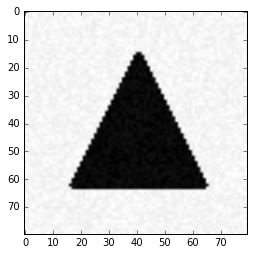

In [4]:
def generate_a_drawing(figsize, U, V, noise=0.0):
    fig = plt.figure(figsize=(figsize,figsize))
    ax = plt.subplot(111)
    plt.axis('Off')
    ax.set_xlim(0,figsize)
    ax.set_ylim(0,figsize)
    ax.fill(U, V, "k")
    fig.canvas.draw()
    imdata = np.frombuffer(fig.canvas.tostring_rgb(), dtype=np.uint8)[::3].astype(np.float32)
    imdata = imdata + noise * np.random.random(imdata.size)
    plt.close(fig)
    return imdata

def generate_a_rectangle(noise=0.0, free_location=False):
    figsize = 1.0    
    U = np.zeros(4)
    V = np.zeros(4)
    if free_location:
        corners = np.random.random(4)
        top = max(corners[0], corners[1])
        bottom = min(corners[0], corners[1])
        left = min(corners[2], corners[3])
        right = max(corners[2], corners[3])
    else:
        side = (0.3 + 0.7 * np.random.random()) * figsize
        top = figsize/2 + side/2
        bottom = figsize/2 - side/2
        left = bottom
        right = top
    U[0] = U[1] = top
    U[2] = U[3] = bottom
    V[0] = V[3] = left
    V[1] = V[2] = right
    return generate_a_drawing(figsize, U, V, noise)


def generate_a_disk(noise=0.0, free_location=False):
    figsize = 1.0
    if free_location:
        center = np.random.random(2)
    else:
        center = (figsize/2, figsize/2)
    radius = (0.3 + 0.7 * np.random.random()) * figsize/2
    N = 50
    U = np.zeros(N)
    V = np.zeros(N)
    i = 0
    for t in np.linspace(0, 2*np.pi, N):
        U[i] = center[0] + np.cos(t) * radius
        V[i] = center[1] + np.sin(t) * radius
        i = i + 1
    return generate_a_drawing(figsize, U, V, noise)

def generate_a_triangle(noise=0.0, free_location=False):
    figsize = 1.0
    if free_location:
        U = np.random.random(3)
        V = np.random.random(3)
    else:
        size = (0.3 + 0.7 * np.random.random())*figsize/2
        middle = figsize/2
        U = (middle, middle+size, middle-size)
        V = (middle+size, middle-size, middle-size)
    imdata = generate_a_drawing(figsize, U, V, noise)
    return [imdata, [U[0], V[0], U[1], V[1], U[2], V[2]]]


im = generate_a_rectangle(10, True)
plt.imshow(im.reshape(IMAGE_SIZE,IMAGE_SIZE), cmap='gray')

im = generate_a_disk(10)
plt.imshow(im.reshape(IMAGE_SIZE,IMAGE_SIZE), cmap='gray')

[im, v] = generate_a_triangle(20, False)
plt.imshow(im.reshape(IMAGE_SIZE,IMAGE_SIZE), cmap='gray')

In [6]:
def generate_dataset_classification(nb_samples, noise=0.0, free_location=False):
    # Getting im_size:
    im_size = generate_a_rectangle().shape[0]
    X = np.zeros([nb_samples,im_size])
    Y = np.zeros(nb_samples)
    print('Creating data..')
    for i in range(nb_samples):
        category = np.random.randint(3)
        if category == 0:
            X[i] = generate_a_rectangle(noise, free_location)
        elif category == 1: 
            X[i] = generate_a_disk(noise, free_location)
        else:
            [X[i], V] = generate_a_triangle(noise, free_location)
        Y[i] = category
    X = (X + noise) / (255 + 2 * noise)
    return [X, Y]

## 3 - Simple Classification


In [7]:
np.random.seed(42)

In [8]:
[X_train_1,Y_train_1] = generate_dataset_classification(600, 20, False)
Y_train_1 = np_utils.to_categorical(Y_train_1,3)

Creating data..


### SGD

In [10]:
model_SGD = Sequential()
model_SGD.add(Dense(3, activation='sigmoid',input_shape = (6400,)))

model_SGD.compile(loss='categorical_crossentropy',optimizer='SGD',metrics=['accuracy'])
model_SGD.fit(X_train_1, Y_train_1,batch_size=32, epochs=50, verbose=1,validation_split = 0.1)

Train on 540 samples, validate on 60 samples
Epoch 1/50
540/540 [==============================] - 0s 337us/step - loss: 1.1417 - acc: 0.3074 - val_loss: 1.1758 - val_acc: 0.2833
Epoch 2/50
540/540 [==============================] - 0s 85us/step - loss: 1.0640 - acc: 0.3204 - val_loss: 1.1906 - val_acc: 0.2833
Epoch 3/50
540/540 [==============================] - 0s 78us/step - loss: 1.0921 - acc: 0.3685 - val_loss: 1.0976 - val_acc: 0.4000
Epoch 4/50
540/540 [==============================] - 0s 78us/step - loss: 1.0977 - acc: 0.4074 - val_loss: 1.0973 - val_acc: 0.4000
Epoch 5/50
540/540 [==============================] - 0s 82us/step - loss: 1.0974 - acc: 0.3944 - val_loss: 1.0967 - val_acc: 0.4000
Epoch 6/50
540/540 [==============================] - 0s 78us/step - loss: 1.0966 - acc: 0.3926 - val_loss: 1.0946 - val_acc: 0.4000
Epoch 7/50
540/540 [==============================] - 0s 82us/step - loss: 1.0906 - acc: 0.3870 - val_loss: 1.0500 - val_acc: 0.3500
Epoch 8/50
540/540 [===

### Adam

In [11]:
model_Adam = Sequential()
model_Adam.add(Dense(3, activation='softmax',input_shape = (6400,)))

model_Adam.compile(loss='categorical_crossentropy',optimizer='Adam',metrics=['accuracy'])
model_Adam.fit(X_train_1, Y_train_1,batch_size=32, epochs=10, verbose=1,validation_split = 0.1)

Train on 540 samples, validate on 60 samples
Epoch 1/10
540/540 [==============================] - 0s 371us/step - loss: 2.3883 - acc: 0.4519 - val_loss: 1.3536 - val_acc: 0.5000
Epoch 2/10
540/540 [==============================] - 0s 87us/step - loss: 0.7996 - acc: 0.6833 - val_loss: 0.6050 - val_acc: 0.7000
Epoch 3/10
540/540 [==============================] - 0s 87us/step - loss: 0.4389 - acc: 0.7778 - val_loss: 0.2403 - val_acc: 0.9833
Epoch 4/10
540/540 [==============================] - 0s 85us/step - loss: 0.2356 - acc: 0.9296 - val_loss: 0.2511 - val_acc: 0.8500
Epoch 5/10
540/540 [==============================] - 0s 86us/step - loss: 0.1766 - acc: 0.9741 - val_loss: 0.1517 - val_acc: 1.0000
Epoch 6/10
540/540 [==============================] - 0s 89us/step - loss: 0.1413 - acc: 0.9833 - val_loss: 0.1439 - val_acc: 0.9833
Epoch 7/10
540/540 [==============================] - 0s 84us/step - loss: 0.1148 - acc: 0.9907 - val_loss: 0.1218 - val_acc: 1.0000
Epoch 8/10
540/540 [===

## 4- Visualization

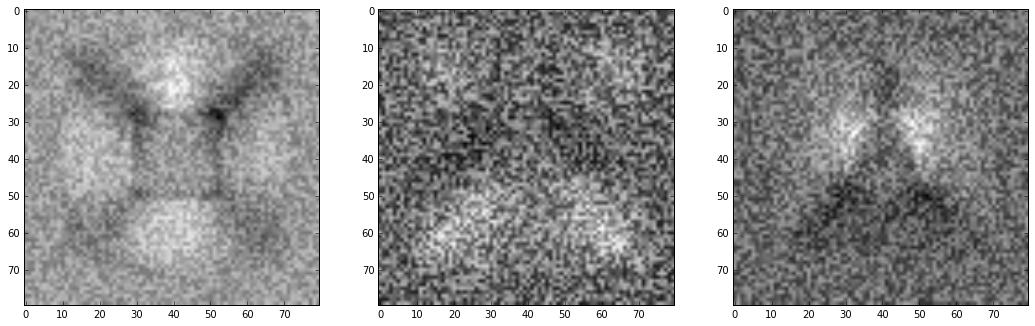

In [13]:
IMAGE_SIZE = 80
plt.figure(figsize = (18,18))

im1 = model_SGD.get_weights()[0][:,0].reshape(-1,1)
plt.subplot(1,3,1)
plt.imshow(im1.reshape(IMAGE_SIZE,IMAGE_SIZE),cmap='gray')

im2 = model_SGD.get_weights()[0][:,1].reshape(-1,1)
plt.subplot(1,3,2)
plt.imshow(im2.reshape(IMAGE_SIZE,IMAGE_SIZE),cmap='gray')

im3 = model_SGD.get_weights()[0][:,2].reshape(-1,1)
plt.subplot(1,3,3)
plt.imshow(im3.reshape(IMAGE_SIZE,IMAGE_SIZE),cmap='gray')

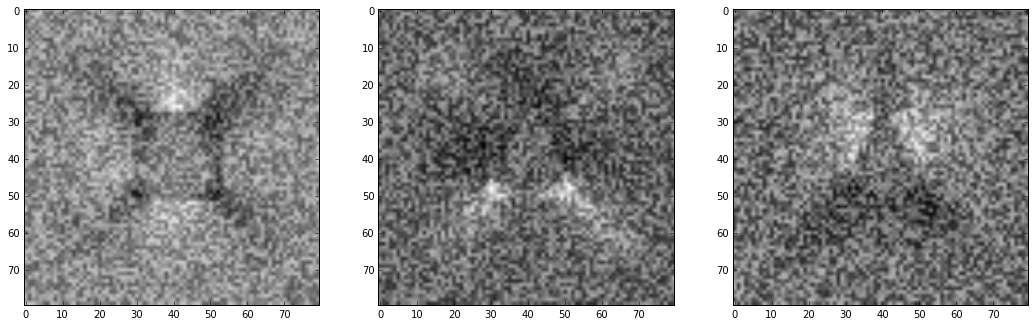

In [14]:
plt.figure(figsize = (18,18))

im1 = model_Adam.get_weights()[0][:,0].reshape(-1,1)
plt.subplot(1,3,1)
plt.imshow(im1.reshape(IMAGE_SIZE,IMAGE_SIZE),cmap='gray')

im2 = model_Adam.get_weights()[0][:,1].reshape(-1,1)
plt.subplot(1,3,2)
plt.imshow(im2.reshape(IMAGE_SIZE,IMAGE_SIZE),cmap='gray')

im3 = model_Adam.get_weights()[0][:,2].reshape(-1,1)
plt.subplot(1,3,3)
plt.imshow(im3.reshape(IMAGE_SIZE,IMAGE_SIZE),cmap='gray')

We can see that the first neuron of the classifier layer does predict rectangles, the second one, disks and the last ones triangles.

Adam is better than SGD in our example.

## 5 - A More Difficult Classification Problem

In [16]:
[X_train_class,Y_train_class] = generate_dataset_classification(1000, 20, True)

X_train_class = X_train_class.reshape(X_train_class.shape[0],80,80,1)
Y_train_class = np_utils.to_categorical(Y_train_class,3)

Creating data..


In [17]:
def generate_test_set_classification():
    np.random.seed(42)
    [X_test, Y_test] = generate_dataset_classification(300, 20, True)
    Y_test = np_utils.to_categorical(Y_test, 3) 
    return [X_test, Y_test]

[X_test_class,Y_test_class] = generate_test_set_classification()

Creating data..


In [18]:
X_test_class = X_test_class.reshape(X_test_class.shape[0],80,80,1)

In [19]:
model = Sequential()
model.add(Conv2D(32, (3, 3), activation='relu',input_shape=(80, 80, 1)))
print(model.output_shape)

model.add(MaxPooling2D(pool_size=(2, 2)))
print(model.output_shape)

model.add(Dropout(0.25))
print(model.output_shape)

model.add(Flatten())
print(model.output_shape)

model.add(Dense(128, activation='relu'))
print(model.output_shape)

model.add(Dropout(0.5))
model.add(Dense(3, activation='softmax'))

print(model.output_shape)

(None, 78, 78, 32)
(None, 39, 39, 32)
(None, 39, 39, 32)
(None, 48672)
(None, 128)
(None, 3)


In [20]:
model.compile(loss='categorical_crossentropy',optimizer='adam',metrics=['accuracy'])
model.fit(X_train_class, Y_train_class,batch_size=32, epochs=10, verbose=1)

Epoch 1/10
1000/1000 [==============================] - 6s 6ms/step - loss: 3.4540 - acc: 0.3540
Epoch 2/10
1000/1000 [==============================] - 5s 5ms/step - loss: 0.9774 - acc: 0.5140
Epoch 3/10
1000/1000 [==============================] - 5s 5ms/step - loss: 0.8227 - acc: 0.6340
Epoch 4/10
1000/1000 [==============================] - 5s 5ms/step - loss: 0.6844 - acc: 0.7220
Epoch 5/10
1000/1000 [==============================] - 5s 5ms/step - loss: 0.5931 - acc: 0.7690
Epoch 6/10
1000/1000 [==============================] - 5s 5ms/step - loss: 0.5249 - acc: 0.8030
Epoch 7/10
1000/1000 [==============================] - 5s 5ms/step - loss: 0.4212 - acc: 0.8680
Epoch 8/10
1000/1000 [==============================] - 5s 5ms/step - loss: 0.3660 - acc: 0.8750
Epoch 9/10
1000/1000 [==============================] - 5s 5ms/step - loss: 0.3025 - acc: 0.9150
Epoch 10/10
1000/1000 [==============================] - 5s 5ms/step - loss: 0.2592 - acc: 0.9320


In [21]:
print('%s = %.2f%%'%(model.metrics_names[1],model.evaluate(X_test_class,Y_test_class)[1]*100))

300/300 [==============================] - 0s 1ms/step
acc = 84.33%


The model yields pretty good results. The accuracy is 84.33% with this model.

## 6 - A Regression Problem


In [22]:
def generate_dataset_regression(nb_samples, noise=0.0):
    # Getting im_size:
    im_size = generate_a_triangle()[0].shape[0]
    X = np.zeros([nb_samples,im_size])
    Y = np.zeros([nb_samples, 6])
    print('Creating data..')
    for i in range(nb_samples):
#         if i % 10 == 0:
#             print(i)
        [X[i], Y[i]] = generate_a_triangle(noise, True)

        Y[i] = np.array(sorted( Y[i].reshape(3,2), key = lambda x: x[0])).reshape(6,)
    
    X = (X + noise) / (255 + 2 * noise)
    return [X, Y]

In [23]:
[X_train_reg,Y_train_reg] = generate_dataset_regression(1000,20)

X_train_reg = X_train_reg.reshape(X_train_reg.shape[0],80,80,1)

def generate_test_set_regression():
  np.random.seed(42)
  [X_test, Y_test] = generate_dataset_regression(300, 20)
  return [X_test, Y_test]

[X_test_reg,Y_test_reg] = generate_test_set_regression()
X_test_reg = X_test_reg.reshape(X_test_reg.shape[0],80,80,1)

Creating data..
Creating data..


In [24]:
model_reg = Sequential()

model_reg.add(Conv2D(32, kernel_size = (3,3),  input_shape = (80,80,1)))

model_reg.add(Conv2D(64, kernel_size = (4,4)))
model_reg.add(MaxPooling2D(pool_size=(3, 3)))

model_reg.add(Conv2D(64, kernel_size = (3,3)))

model_reg.add(Flatten())

model_reg.add(Dense(128, activation='relu'))
model_reg.add( Dropout(0.2))
model_reg.add(Dense(6, activation='sigmoid'))

model_reg.compile(optimizer='adam', loss= 'mean_squared_error', metrics=['mse'])
model_reg.summary()

model_reg.fit(1-X_train_reg, Y_train_reg, epochs=10, batch_size = 32, validation_split = 0.1)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_2 (Conv2D)            (None, 78, 78, 32)        320       
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 75, 75, 64)        32832     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 25, 25, 64)        0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 23, 23, 64)        36928     
_________________________________________________________________
flatten_2 (Flatten)          (None, 33856)             0         
_________________________________________________________________
dense_6 (Dense)              (None, 128)               4333696   
_________________________________________________________________
dropout_3 (Dropout)          (None, 128)               0         
__________

Our solution yields MSE = 0.0143 on the validation set, which is a good score. It is based on 3 convolutional neural networks, a max pooling, a linear hidden layer and a classifier using the sigmoid activation.

In [27]:
import matplotlib.patches as patches

In [29]:
def visualize_prediction(x, y):
    fig, ax = plt.subplots(figsize=(5, 5))
    I = x.reshape((IMAGE_SIZE,IMAGE_SIZE))
    ax.imshow(I, extent=[-0.15,1.15,-0.15,1.15],cmap='gray')
    ax.set_xlim([0,1])
    ax.set_ylim([0,1])

    xy = y.reshape(3,2)
    tri = patches.Polygon(xy, closed=True, fill = False, edgecolor = 'r', linewidth = 5, alpha = 0.5)
    ax.add_patch(tri)

    plt.show()

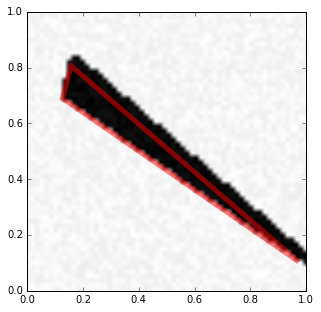

In [30]:
visualize_prediction(X_train_reg[1],Y_train_reg[1])

In [32]:
y_pred = model_reg.predict(1-X_test_reg)

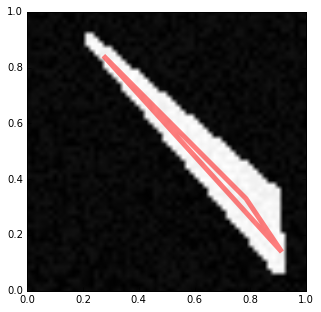

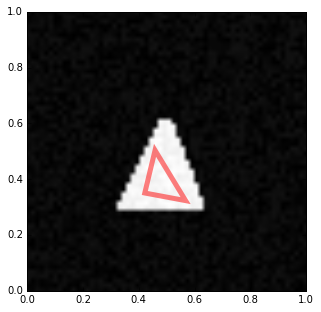

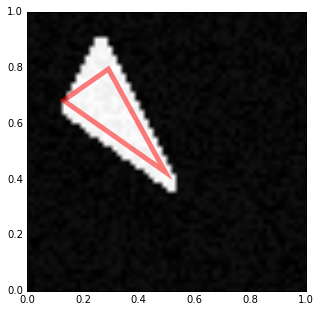

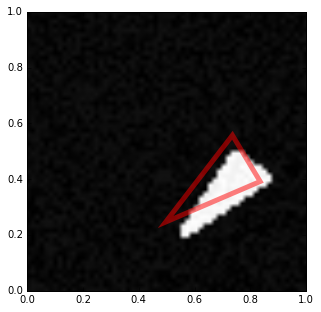

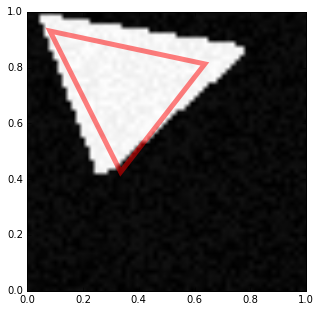

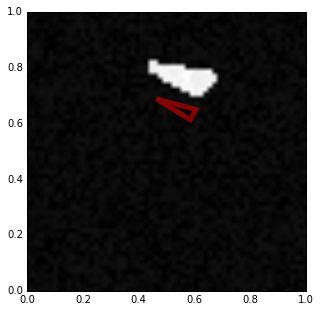

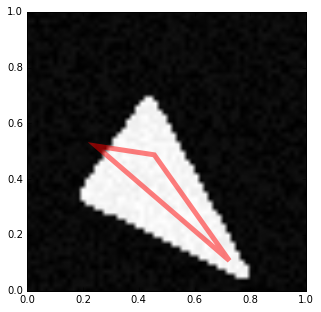

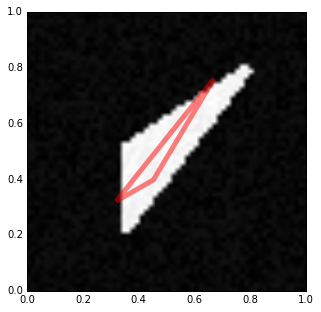

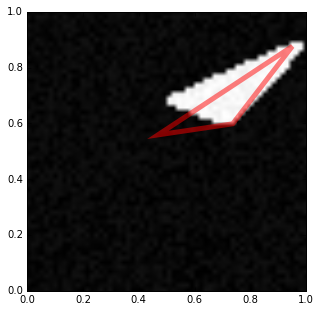

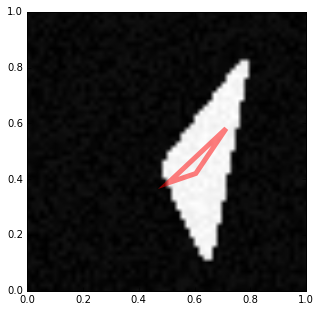

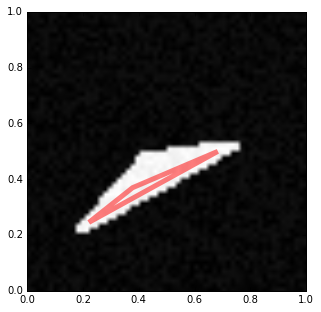

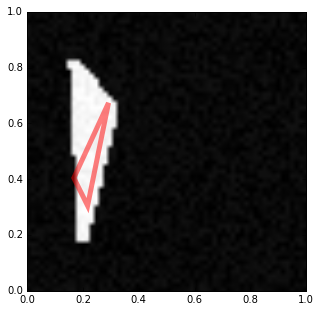

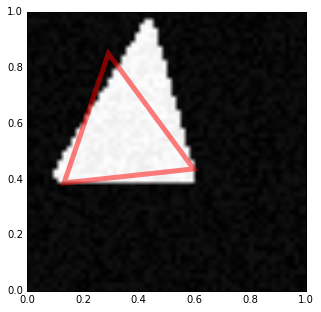

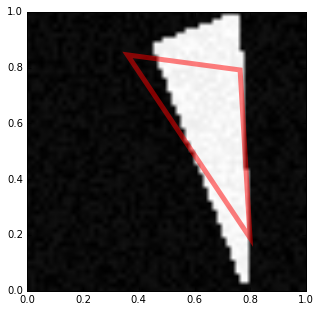

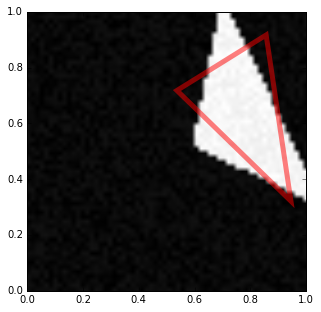

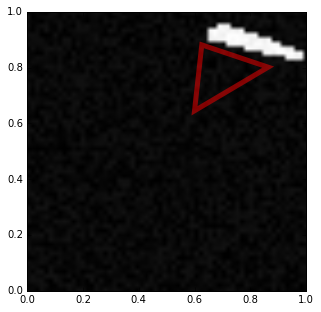

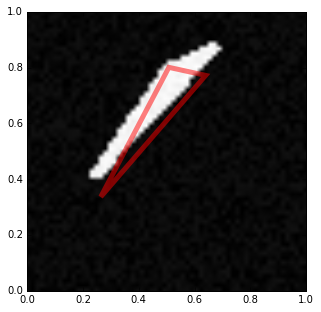

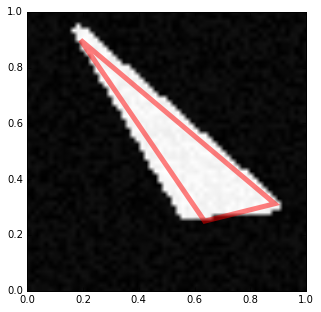

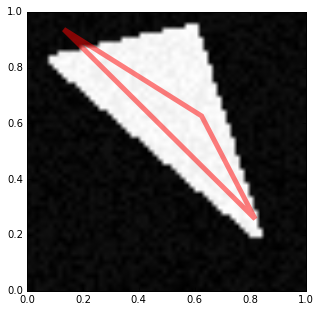

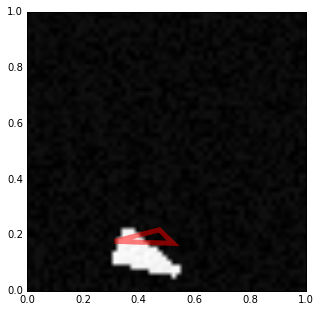

In [33]:
for i in range(20):
    visualize_prediction(1-X_test_reg[i],y_pred[i])

## 7- Image Denoising

In [4]:
def generate_a_drawing_(figsize, U, V):
    fig = plt.figure(figsize=(figsize,figsize))
    ax = plt.subplot(111)
    plt.axis('Off')
    ax.set_xlim(0,figsize)
    ax.set_ylim(0,figsize)
    ax.fill(U, V, "k")
    fig.canvas.draw()
    imdata = np.frombuffer(fig.canvas.tostring_rgb(), dtype=np.uint8)[::3].astype(np.float32)
    noise = np.random.random()*100
    imdata_ = imdata + noise * np.random.random(imdata.size)
    plt.close(fig)
    
    #We return imdata : without noise and imdata_ : with noise
    return imdata,imdata_

  
def generate_a_rectangle_(free_location=False):
    figsize = 1.0    
    U = np.zeros(4)
    V = np.zeros(4)
    if free_location:
        corners = np.random.random(4)
        top = max(corners[0], corners[1])
        bottom = min(corners[0], corners[1])
        left = min(corners[2], corners[3])
        right = max(corners[2], corners[3])
    else:
        side = (0.3 + 0.7 * np.random.random()) * figsize
        top = figsize/2 + side/2
        bottom = figsize/2 - side/2
        left = bottom
        right = top
    U[0] = U[1] = top
    U[2] = U[3] = bottom
    V[0] = V[3] = left
    V[1] = V[2] = right
    
    imdata,imdata_ = generate_a_drawing_(figsize, U, V)
    
    return imdata.reshape(IMAGE_SIZE,IMAGE_SIZE), imdata_.reshape(IMAGE_SIZE,IMAGE_SIZE)


def generate_a_disk_(free_location=False):
    figsize = 1.0
    if free_location:
        center = np.random.random(2)
    else:
        center = (figsize/2, figsize/2)
    radius = (0.3 + 0.7 * np.random.random()) * figsize/2
    N = 50
    U = np.zeros(N)
    V = np.zeros(N)
    i = 0
    for t in np.linspace(0, 2*np.pi, N):
        U[i] = center[0] + np.cos(t) * radius
        V[i] = center[1] + np.sin(t) * radius
        i = i + 1

    imdata, imdata_ = generate_a_drawing_(figsize, U, V)
    
    return imdata.reshape(IMAGE_SIZE,IMAGE_SIZE), imdata_.reshape(IMAGE_SIZE,IMAGE_SIZE)

  
def generate_a_triangle_(free_location=False):
    figsize = 1.0
    if free_location:
        U = np.random.random(3)
        V = np.random.random(3)
    else:
        size = (0.3 + 0.7 * np.random.random())*figsize/2
        middle = figsize/2
        U = (middle, middle+size, middle-size)
        V = (middle+size, middle-size, middle-size)
    imdata,imdata_ = generate_a_drawing_(figsize, U, V)
    return imdata.reshape(IMAGE_SIZE,IMAGE_SIZE) ,imdata_.reshape(IMAGE_SIZE,IMAGE_SIZE)

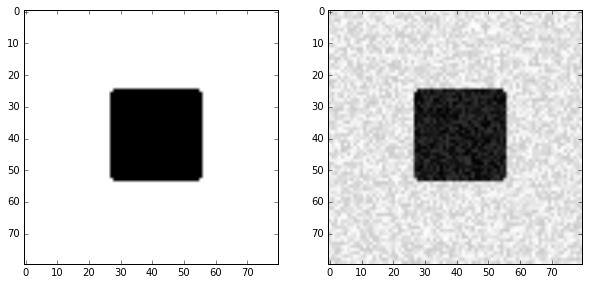

In [5]:
plt.figure(figsize = (10,10))

clean_image,noisy_image = generate_a_rectangle_()

plt.subplot(1,2,1)
plt.imshow(clean_image, cmap = 'gray')

plt.subplot(1,2,2)
plt.imshow(noisy_image,cmap = 'gray')

In [6]:
#On crée le dataset d'entraînement et de test

def generate_dataset(n_samples, ratio_test):
  '''
  Generates train/test datasets for the hourglass network. 
  Output:
     X_train : Noisy images
     Y_train : Noise-free images
     X_test  : Noisy test images
     Y_test  : Noise-free test images
  '''
  im_size = generate_a_rectangle_()[0].shape[0]
  X_ = np.zeros((n_samples,2,im_size,im_size))
  
  for i in range(n_samples):
    
    category = np.random.randint(3)
    if category == 0:
      X_[i] = generate_a_rectangle_()
    if category == 1:
      X_[i] = generate_a_disk_()
    else:
      X_[i] = generate_a_triangle_()
    
    if i % 200 == 0 :
        print(i)
    
  X_test = X_[:int(ratio_test*n_samples),1] #With noise
  Y_test = X_[:int(ratio_test*n_samples),0] #Without noise

  X_train  = X_[int(ratio_test*n_samples):,1] #With noise
  Y_train  = X_[int(ratio_test*n_samples):,0] #Without noise
    
  X_train = X_train.reshape(X_train.shape[0],IMAGE_SIZE,IMAGE_SIZE,1)
  Y_train = Y_train.reshape(Y_train.shape[0],IMAGE_SIZE,IMAGE_SIZE,1)
  X_test  = X_test.reshape(X_test.shape[0],IMAGE_SIZE,IMAGE_SIZE,1)
  Y_test  = Y_test.reshape(Y_test.shape[0],IMAGE_SIZE,IMAGE_SIZE,1)
  
  return X_train,Y_train,X_test,Y_test

In [7]:
X_train,Y_train,X_test,Y_test = generate_dataset(5000,0.2)

0
200
400
600
800
1000
1200
1400
1600
1800
2000
2200
2400
2600
2800
3000
3200
3400
3600
3800
4000
4200
4400
4600
4800


In [8]:
X_train.shape

(4000, 80, 80, 1)

### Model

In [9]:
hourglass_net = Sequential()

hourglass_net.add(Conv2D(64, kernel_size = (3, 3), activation='relu', padding='same',  input_shape = (80,80,1)))
hourglass_net.add(Conv2D(32, kernel_size = (3, 3), activation='relu',padding='same'))
hourglass_net.add(MaxPooling2D(pool_size= (2, 2)))
hourglass_net.add(Conv2D(16, kernel_size = (3, 3),activation='relu' , padding='same'))

print(hourglass_net.output_shape)

hourglass_net.add(Conv2D(16, kernel_size = (3, 3),activation='relu', padding='same'))
hourglass_net.add(UpSampling2D(size = (2, 2)))
hourglass_net.add(Conv2D(32, kernel_size = (3, 3),activation='relu', padding='same'))
hourglass_net.add(Conv2D(64, kernel_size = (3, 3), activation='relu',padding='same'))

hourglass_net.add(Conv2D(1, kernel_size = (3, 3),activation='relu', padding='same'))

print(hourglass_net.output_shape)

(None, 40, 40, 16)
(None, 80, 80, 1)


In [10]:
hourglass_net.compile(optimizer='adam', loss= 'mean_squared_error', metrics=['mse'])
hourglass_net.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 80, 80, 64)        640       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 80, 80, 32)        18464     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 40, 40, 32)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 40, 40, 16)        4624      
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 40, 40, 16)        2320      
_________________________________________________________________
up_sampling2d_1 (UpSampling2 (None, 80, 80, 16)        0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 80, 80, 32)        4640      
__________

In [ ]:
from keras.callbacks import ModelCheckpoint

weight_save_callback = ModelCheckpoint('weights.{epoch:02d}-{val_loss:.2f}.hdf5', monitor='val_loss', verbose=0, save_best_only=False, mode='auto')

h = hourglass_net.fit(X_train, Y_train, epochs= 20, batch_size = 100, validation_data = (X_test, Y_test),callbacks = [weight_save_callback])

Train on 4000 samples, validate on 1000 samples
Epoch 1/20
4000/4000 [==============================] - 279s 70ms/step - loss: 148.1215 - mean_squared_error: 148.1195 - val_loss: 96.6893 - val_mean_squared_error: 96.6880
Epoch 2/20
4000/4000 [==============================] - 278s 69ms/step - loss: 72.6623 - mean_squared_error: 72.6614 - val_loss: 49.0500 - val_mean_squared_error: 49.0491
Epoch 3/20
4000/4000 [==============================] - 279s 70ms/step - loss: 82.0523 - mean_squared_error: 82.0517 - val_loss: 39.5207 - val_mean_squared_error: 39.5202
Epoch 4/20
4000/4000 [==============================] - 279s 70ms/step - loss: 34.2888 - mean_squared_error: 34.2882 - val_loss: 29.0372 - val_mean_squared_error: 29.0367
Epoch 5/20
4000/4000 [==============================] - 278s 69ms/step - loss: 26.5038 - mean_squared_error: 26.5034 - val_loss: 23.9402 - val_mean_squared_error: 23.9399
Epoch 6/20
4000/4000 [==============================] - 279s 70ms/step - loss: 23.3772 - mean_s

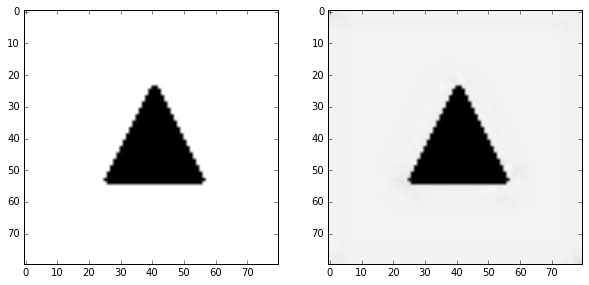

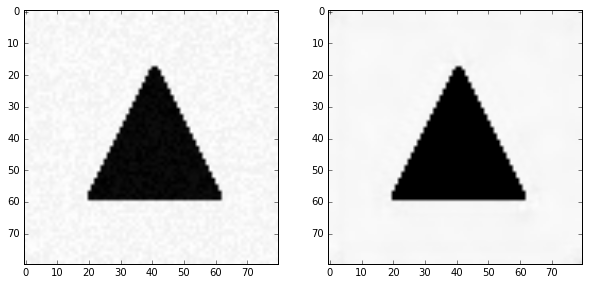

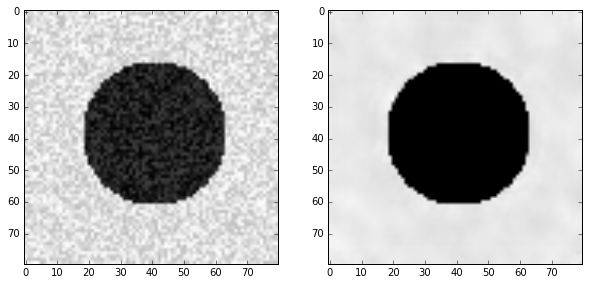

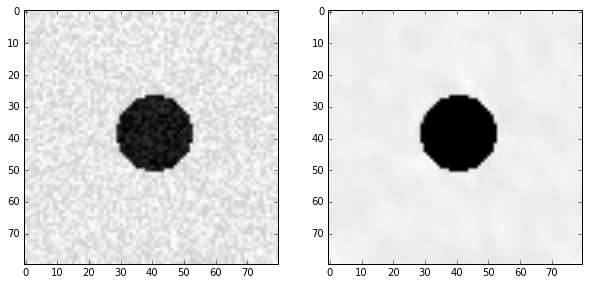

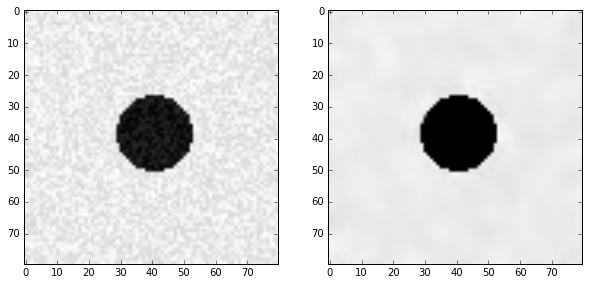

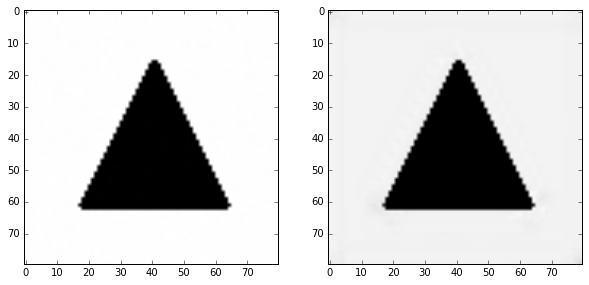

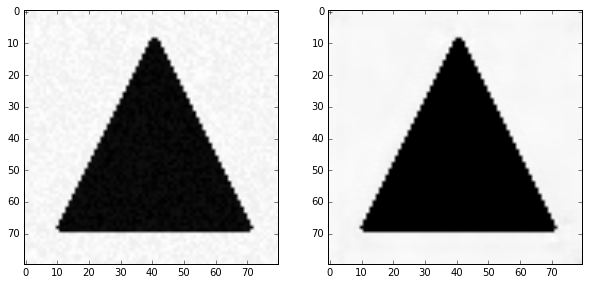

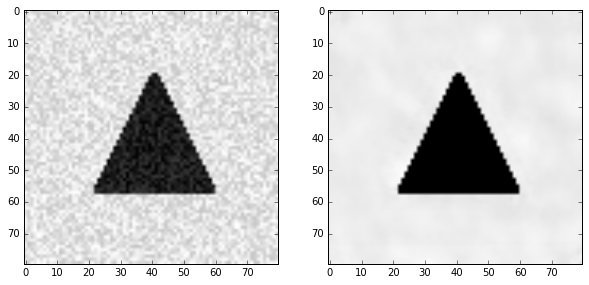

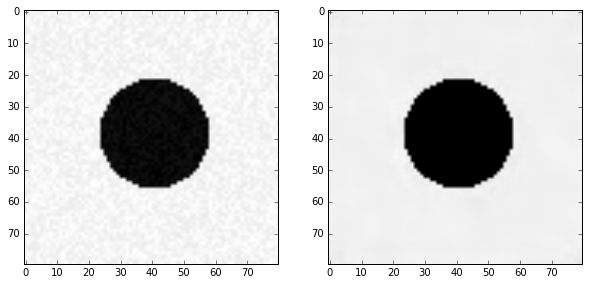

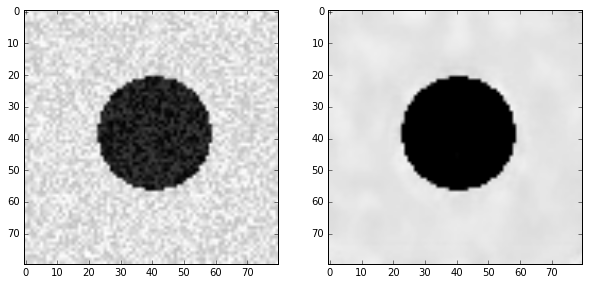

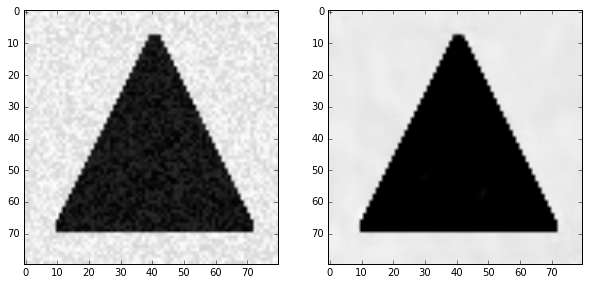

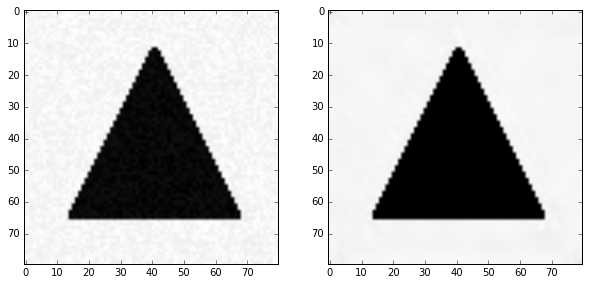

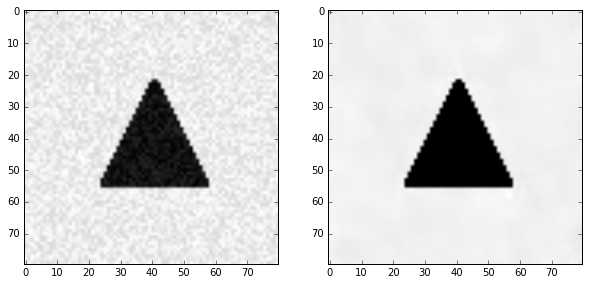

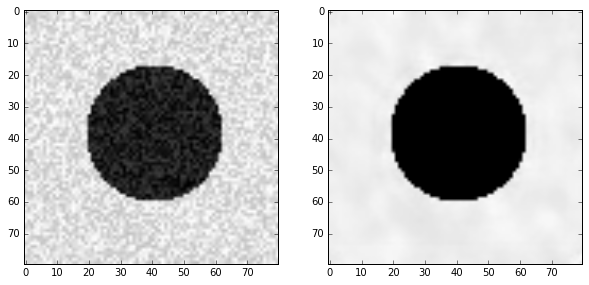

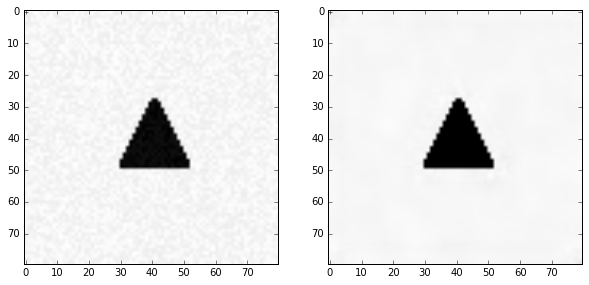

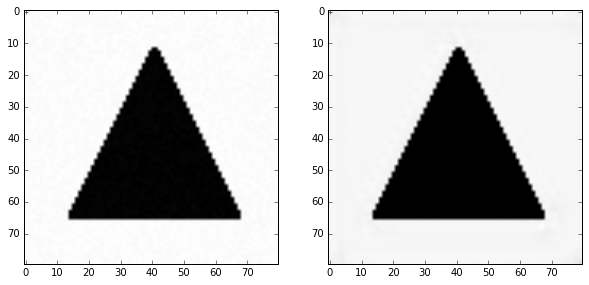

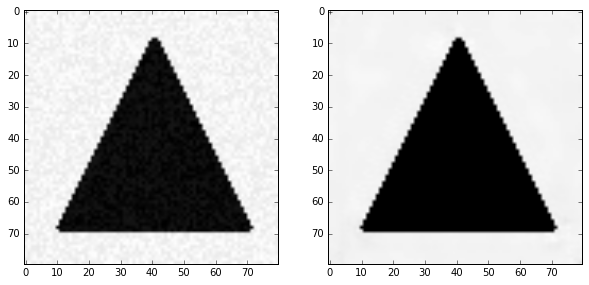

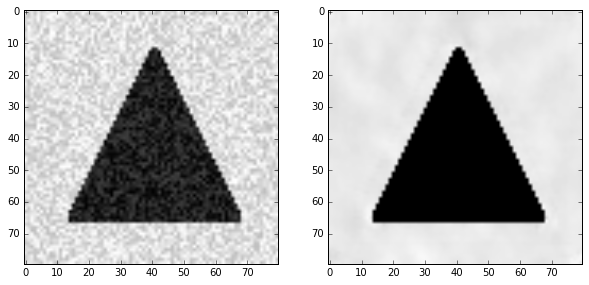

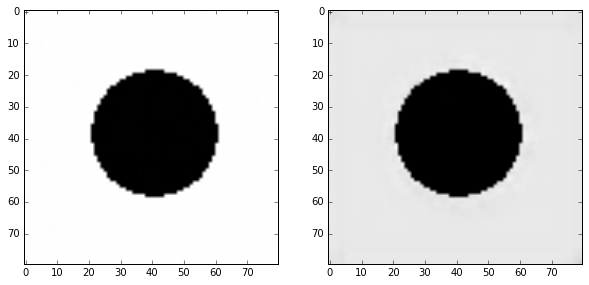

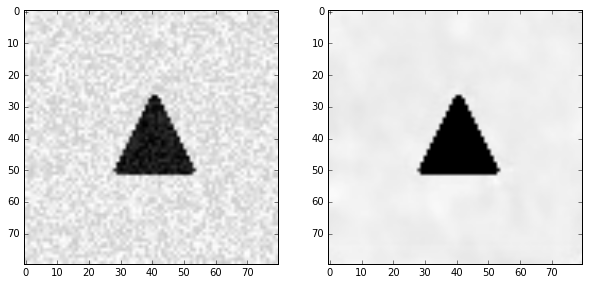

In [14]:
hourglass_net.load_weights("weights.17-9.65.hdf5")

X_test_pred = hourglass_net.predict(X_test)

for i in range(20):
    plt.figure(figsize = (10,10))

    clean_image  = X_test_pred[i]
    noisy_image = X_test[i]

    plt.subplot(1,2,1)
    plt.imshow(noisy_image.reshape(80,80), cmap = 'gray')

    plt.subplot(1,2,2)
    plt.imshow(clean_image.reshape(80,80),cmap = 'gray')